# Strategies

In [5]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import dataset
import betting
import csv

import pandas as pd

## Restore model from checkpoint

In [296]:
TRAINING_SET_FRACTION = 0.75

data = dataset.Dataset('data/book.csv')

train_results_len = int(TRAINING_SET_FRACTION * len(data.processed_results))
train_results = data.processed_results[:train_results_len]
test_results = data.processed_results[train_results_len:]

def map_results(results):
    features = {}

    for result in results:
        for key in result.keys():
            if key not in features:
                features[key] = []

            features[key].append(result[key])

    for key in features.keys():
        features[key] = np.array(features[key])

    return features, features['result']

train_features, train_labels = map_results(train_results)
test_features, test_labels = map_results(test_results)

train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=train_features,
    y=train_labels,
    batch_size=500,
    num_epochs=None,
    shuffle=True
)

test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=test_features,
    y=test_labels,
    num_epochs=1,
    shuffle=False
)

feature_columns = []

for mode in ['home', 'away']:
    feature_columns = feature_columns + [
        tf.feature_column.numeric_column(key='{}-wins'.format(mode)),
        tf.feature_column.numeric_column(key='{}-draws'.format(mode)),
        tf.feature_column.numeric_column(key='{}-losses'.format(mode)),
        tf.feature_column.numeric_column(key='{}-goals'.format(mode)),
        tf.feature_column.numeric_column(key='{}-opposition-goals'.format(mode)),
        tf.feature_column.numeric_column(key='{}-shots'.format(mode)),
        tf.feature_column.numeric_column(key='{}-shots-on-target'.format(mode)),
        tf.feature_column.numeric_column(key='{}-opposition-shots'.format(mode)),
        tf.feature_column.numeric_column(key='{}-opposition-shots-on-target'.format(mode)),
    ]

model = tf.estimator.DNNClassifier(
    model_dir='model/',
    hidden_units=[10],
    feature_columns=feature_columns,
    n_classes=3,
    label_vocabulary=['H', 'D', 'A'],
    optimizer=tf.train.ProximalAdagradOptimizer(
        learning_rate=0.1,
        l1_regularization_strength=0.001
    ))

predictions = list(model.predict(input_fn=test_input_fn))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'model/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000207D8583DA0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from model/model.ckpt-20000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [382]:
# 'Vectorised' code:

bank = 10000

starting_decimal_odds_list = []
probability_of_win_list = []
winner_list = []

for i in range(0, len(predictions)):
    starting_decimal_odds_list = starting_decimal_odds_list + [test_features['odds-home'][i], test_features['odds-draw'][i], test_features['odds-away'][i]]
    probability_of_win_list = probability_of_win_list + [predictions[i]['probabilities'][0], predictions[i]['probabilities'][1], predictions[i]['probabilities'][2]]
    if test_features['result'][i] == 'H':
        winner_list = winner_list + [1, 0, 0]
    elif test_features['result'][i] == 'D':
        winner_list = winner_list + [0, 1, 0]
    else:
        winner_list = winner_list + [0, 0, 1]
    
starting_decimal_odds = pd.Series(starting_decimal_odds_list)
probability_of_win = pd.Series(probability_of_win_list)
winner = pd.Series(winner_list)

f_bank = ((starting_decimal_odds - 1.0) * probability_of_win - (1.0 - probability_of_win)) / (starting_decimal_odds - 1.0)
full_kelly_stake = bank * f_bank.abs()

hda_side = (
    pd.Series('back', index=f_bank.index)
    .where(f_bank > 0, 'lay')
    .where(full_kelly_stake >= 1.0, 'neutral')
    .where(probability_of_win < 0.5, 'neutral')
    .where(probability_of_win > 0.2, 'neutral')
    #.where(full_kelly_stake <= 2000.0, 'neutral')
)
hda_stake = full_kelly_stake.where(full_kelly_stake >= 2.0, 0)#.where(full_kelly_stake <= 20.0, 0)

In [383]:
hda_side_factor = (
    pd.Series(0.0, index=hda_side.index)
    .where(hda_side=='back', 1.0)
    .where(hda_side=='lay', -1.0)
)

hda_pnl = (
    pd.Series((starting_decimal_odds - 1.0) * hda_stake * hda_side_factor, index=f_bank.index)
    .where(winner == 1, -1.0 * hda_stake * hda_side_factor)
)


In [384]:
pnl_1_h = []
pnl_1_d = []
pnl_1_a = []

for i in range(0, len(predictions)):
    pnl_1_h = pnl_1_h + [hda_pnl[i*3]]
    pnl_1_d = pnl_1_d + [hda_pnl[i*3 + 1]]
    pnl_1_a = pnl_1_a + [hda_pnl[i*3 + 2]]


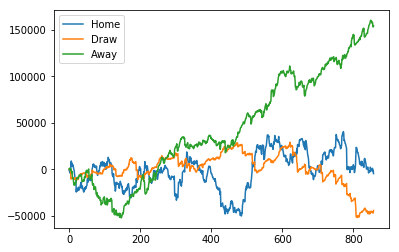

In [385]:
pd.Series(pnl_1_h).cumsum().plot()
pd.Series(pnl_1_d).cumsum().plot()
pd.Series(pnl_1_a).cumsum().plot()
plt.legend(['Home', 'Draw', 'Away'])

In [386]:
print('Biggest loss on home: ', '%.0f' % pd.Series(pnl_1_h).min(), '\t', 'Biggest win: ', '%.0f' % pd.Series(pnl_1_h).max(), '\t', 'Average: ', '%.0f' % pd.Series(pnl_1_h).mean(), '\t', 'Final PnL: ', '%.0f' % pd.Series(pnl_1_h).cumsum()[pd.Series(pnl_1_h).index[-1]], '\t', 'Std: ', '%.0f' % pd.Series(pnl_1_h).std())
print('Biggest loss on draw: ', '%.0f' % pd.Series(pnl_1_d).min(), '\t', 'Biggest win: ', '%.0f' % pd.Series(pnl_1_d).max(), '\t', 'Average: ', '%.0f' % pd.Series(pnl_1_d).mean(), '\t', 'Final PnL: ', '%.0f' % pd.Series(pnl_1_d).cumsum()[pd.Series(pnl_1_d).index[-1]], '\t', 'Std: ', '%.0f' % pd.Series(pnl_1_d).std())
print('Biggest loss on away: ', '%.0f' % pd.Series(pnl_1_a).min(), '\t', 'Biggest win: ', '%.0f' % pd.Series(pnl_1_a).max(), '\t', 'Average: ', '%.0f' % pd.Series(pnl_1_a).mean(), '\t', 'Final PnL: ', '%.0f' % pd.Series(pnl_1_a).cumsum()[pd.Series(pnl_1_a).index[-1]], '\t', 'Std: ', '%.0f' % pd.Series(pnl_1_a).std())

Biggest loss on home:  -22000 	 Biggest win:  10624 	 Average:  -5 	 Final PnL:  -4464 	 Std:  3179
Biggest loss on draw:  -11916 	 Biggest win:  4437 	 Average:  -51 	 Final PnL:  -44136 	 Std:  1810
Biggest loss on away:  -12478 	 Biggest win:  10314 	 Average:  180 	 Final PnL:  154514 	 Std:  2160


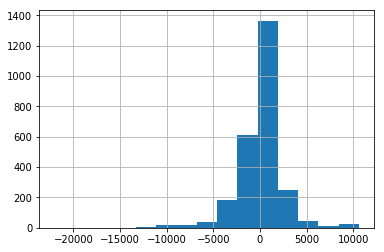

In [387]:
hda_pnl.hist(bins=15)

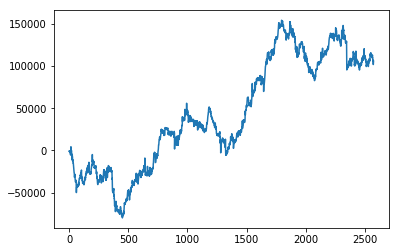

In [388]:
hda_pnl.cumsum().plot()

In [389]:
hda_pnl.mean()

41.147797858573696

In [390]:
hda_pnl.cumsum().max()

154448.22909028723

### Fractional Kelly

In [391]:
bank_2 = [10000]
full_kelly_stake_2_h = []
full_kelly_stake_2_d = []
full_kelly_stake_2_a = []
pnl_2_h = []
pnl_2_d = []
pnl_2_a = []
pnl_2 = []

pct_bnk = 0.1

for i in range(0, len(predictions)):
    full_kelly_stake_2_h = full_kelly_stake_2_h + [bank_2[i] * np.absolute(f_bank[i*3]) / 3.0 * pct_bnk]
    full_kelly_stake_2_d = full_kelly_stake_2_d + [bank_2[i] * np.absolute(f_bank[i*3 + 1]) / 3.0 * pct_bnk]
    full_kelly_stake_2_a = full_kelly_stake_2_a + [bank_2[i] * np.absolute(f_bank[i*3 + 2]) / 3.0 * pct_bnk]
  
    if winner[i*3] == 1:
        pnl_2_h = pnl_2_h + [(starting_decimal_odds[i*3] - 1.0) * full_kelly_stake_2_h[i] * hda_side_factor[i*3]]
        pnl_2_d = pnl_2_d + [-1.0 * full_kelly_stake_2_d[i] * hda_side_factor[i*3 + 1]]
        pnl_2_a = pnl_2_a + [-1.0 * full_kelly_stake_2_a[i] * hda_side_factor[i*3 + 2]]
    elif winner[i*3 + 1] == 1:
        pnl_2_h = pnl_2_h + [-1.0 * full_kelly_stake_2_h[i] * hda_side_factor[i*3]]
        pnl_2_d = pnl_2_d + [(starting_decimal_odds[i*3 + 1] - 1.0) * full_kelly_stake_2_d[i] * hda_side_factor[i*3 + 1]]
        pnl_2_a = pnl_2_a + [-1.0 * full_kelly_stake_2_a[i] * hda_side_factor[i*3 + 2]]
    else:
        pnl_2_h = pnl_2_h + [-1.0 * full_kelly_stake_2_h[i] * hda_side_factor[i*3]]
        pnl_2_d = pnl_2_d + [-1.0 * full_kelly_stake_2_d[i] * hda_side_factor[i*3 + 1]]
        pnl_2_a = pnl_2_a + [(starting_decimal_odds[i*3 + 2] - 1.0) * full_kelly_stake_2_a[i] * hda_side_factor[i*3 + 2]]

    bank_2 = bank_2 + [bank_2[i] + pnl_2_h[i] + pnl_2_d[i] + pnl_2_a[i]]

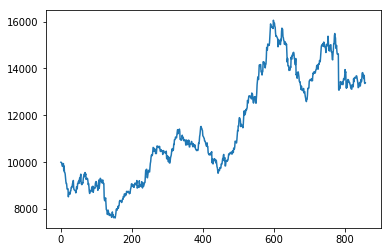

In [392]:
pd.Series(bank_2).plot()

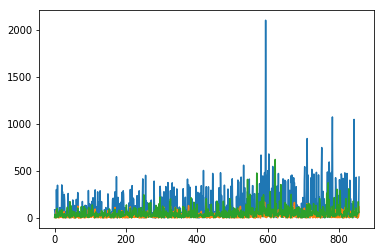

In [393]:
#full_kelly_stake_2
#pnl_2
pd.Series(full_kelly_stake_2_h).plot()
pd.Series(full_kelly_stake_2_d).plot()
pd.Series(full_kelly_stake_2_a).plot()

In [394]:
pd.Series(bank_2)[pd.Series(bank_2).index[-1]]

13381.373152862827

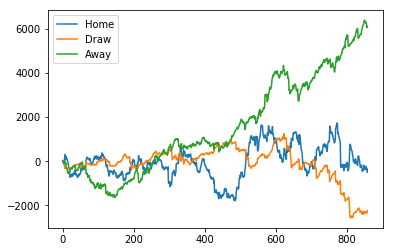

In [395]:
pd.Series(pnl_2_h).cumsum().plot()
pd.Series(pnl_2_d).cumsum().plot()
pd.Series(pnl_2_a).cumsum().plot()
#(pd.Series(pnl_2_h) + pd.Series(pnl_2_d) + pd.Series(pnl_2_a)).cumsum().plot()
plt.legend(['Home', 'Draw', 'Away'])

In [381]:
print('Biggest loss on home: ', '%.0f' % pd.Series(pnl_2_h).min(), '\t', 'Biggest win: ', '%.0f' % pd.Series(pnl_2_h).max(), '\t', 'Average: ', '%.0f' % pd.Series(pnl_2_h).mean(), '\t', 'Final PnL: ', '%.0f' % pd.Series(pnl_2_h).cumsum()[pd.Series(pnl_2_h).index[-1]], '\t', 'Std: ', '%.0f' % pd.Series(pnl_2_h).std())
print('Biggest loss on draw: ', '%.0f' % pd.Series(pnl_2_d).min(), '\t', 'Biggest win: ', '%.0f' % pd.Series(pnl_2_d).max(), '\t', 'Average: ', '%.0f' % pd.Series(pnl_2_d).mean(), '\t', 'Final PnL: ', '%.0f' % pd.Series(pnl_2_d).cumsum()[pd.Series(pnl_2_d).index[-1]], '\t', 'Std: ', '%.0f' % pd.Series(pnl_2_d).std())
print('Biggest loss on away: ', '%.0f' % pd.Series(pnl_2_a).min(), '\t', 'Biggest win: ', '%.0f' % pd.Series(pnl_2_a).max(), '\t', 'Average: ', '%.0f' % pd.Series(pnl_2_a).mean(), '\t', 'Final PnL: ', '%.0f' % pd.Series(pnl_2_a).cumsum()[pd.Series(pnl_2_a).index[-1]], '\t', 'Std: ', '%.0f' % pd.Series(pnl_2_a).std())

Biggest loss on home:  -678 	 Biggest win:  977 	 Average:  2 	 Final PnL:  1352 	 Std:  119
Biggest loss on draw:  -529 	 Biggest win:  161 	 Average:  -2 	 Final PnL:  -1941 	 Std:  69
Biggest loss on away:  -420 	 Biggest win:  387 	 Average:  7 	 Final PnL:  5896 	 Std:  80


In [319]:
def test_betting_stategy(predictions, test_features, test_labels, bet_difference=0.05):
    result = {
        'spend': 0,
        'return': 0,
    }

    for i in range(0, len(predictions)):
        probabilities = predictions[i]['probabilities']

        if probabilities[1] > (1 / test_features['odds-draw'][i]) + bet_difference:
            result['spend'] = result['spend'] + 1

            if test_labels[i] == 'D':
                result['return'] = result['return'] + test_features['odds-draw'][i]

    result['performance'] = result['return'] / result['spend']

    return result

In [313]:
test_betting_stategy(predictions, test_features, test_labels, bet_difference=0.1)

{'spend': 13, 'return': 6.5, 'performance': 0.5}